# Test student-t likelihood with NS

In [1]:
%run init.ipy

from lib import constants
from lib import klatt
from lib import util

import random
from vtr.prior import formant
from lib import timit

from inv import process, model
from vtr.prior import filter

2023-01-12 17:27:12.529941: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-12 17:27:12.529986: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-12 17:27:12.529991: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Get some test data from VTRFormants ***TEST*** set

In [2]:
def rand_triple():
    vtr_root = timit.test_set(timit.VTRFORMANTS)
    timit_root = timit.test_set(timit.TIMIT)
    l = list(timit.yield_file_triples(vtr_root, timit_root))
    return random.choice(l)

fb_file, phn_file, wav_file = rand_triple()

NP = 10
Number of data points: 768
Number of model dimensions: 112


3749.999999999999

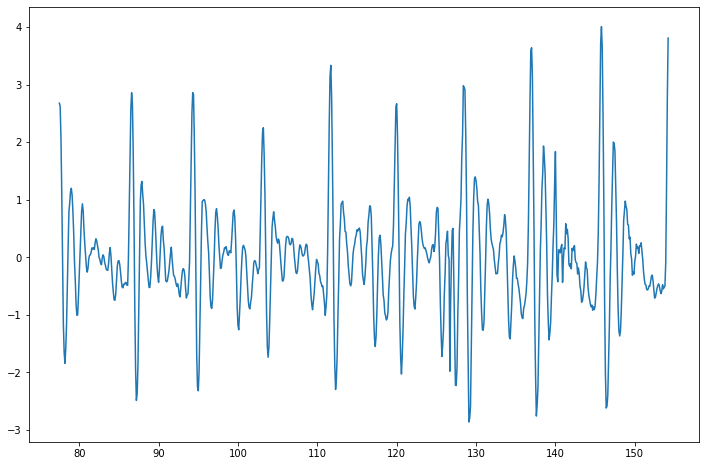

In [48]:
from inv import process
from vtr.prior import filter
import jax

source_config = dict(
    kernel_name = "Matern32Kernel",
    kernel_M = 128,
    use_oq = True,
    impose_null_integral = True
)

vtfilter = filter.AP(3, numpy_backend=jax.numpy, scipy_backend=jax.scipy)

hyper = process.make_rand_hyper(
    (fb_file, phn_file, wav_file),
    source_config = source_config,
    vtfilter = vtfilter,
    #process_data_kwargs=dict(max_NP = 2, prepend=1)
)

hyper['meta']['noiseless_estimates'] = True

plot(hyper['data']['t'], hyper['data']['d'])
print("NP =", hyper['data']['NP'])
print("Number of data points:", len(hyper['data']['d']))
print("Number of model dimensions:", model.ndim(hyper))

display(klatt.play(hyper['data']['t'], hyper['data']['d']))

model.rough_frequency_limit(hyper)

## AB testing: Hilbert logl

In [49]:
import dynesty
import scipy
from inv import model

theta_bijector = model.theta_trajectory_bijector(hyper)
    
@jax.jit
def loglike(w):
    theta = theta_bijector.forward(w)
    logl = model.full_likelihood(theta, hyper)
    return logl

ptform = scipy.special.ndtri

ndim = model.ndim(hyper)
ndim

[Memory]589.2s, 9.8min  : Loading posterior_of_fitted_lf_values...
[Memory]589.2s, 9.8min  : Loading run_nested...
[Memory]589.2s, 9.8min  : Loading posterior_of_fitted_TFB_values...
[Memory]589.5s, 9.8min  : Loading run_nested...


112

In [50]:
def get_SNR(
    results,
    _noise_sigma_bijector = model.noise_sigma_bijector()
):
    v = results[2][0]
    sigma = float(_noise_sigma_bijector.forward(v))
    SNR = 20.*np.log10(sigma)
    return np.round(SNR, 2)

def progress(results, *args, **kwargs):
    SNR = get_SNR(results)
    kwargs.update({'logl_max': SNR})
    return dynesty.results.print_fn(
        results, *args, **kwargs
    )

SAMPLERARGS = {'sample': 'rslice', 'first_update': {'min_eff': 5.}}
RUNARGS = {'save_bounds': False, 'maxcall': int(1e7)}

sampler = dynesty.NestedSampler(
    loglike, ptform, ndim, nlive=20, **SAMPLERARGS
)

sampler.run_nested(
    print_func=progress,
    **RUNARGS
)
results = sampler.results

/home/marnix/thesis/py/venv/lib/python3.10/site-packages/dynesty/dynesty.py:575: UserWarning: Beware! Having `nlive <= 2 * ndim` is extremely risky!
  warnings.warn(
iter: 103 | bound: 5 | nc: 614 | ncall: 18254 | eff(%):  0.564 | loglstar:   -inf < -515.372 < -10.750 | logz: -524.085 +/-  0.652 | dlogz: 420.187 >  0.029                                          

KeyboardInterrupt: 

Summary
nlive: 20
niter: 219
ncall: 28659
eff(%):  0.834
logz: -14.383 +/-  2.225


None

'Information (bans)'

5.073086556336345

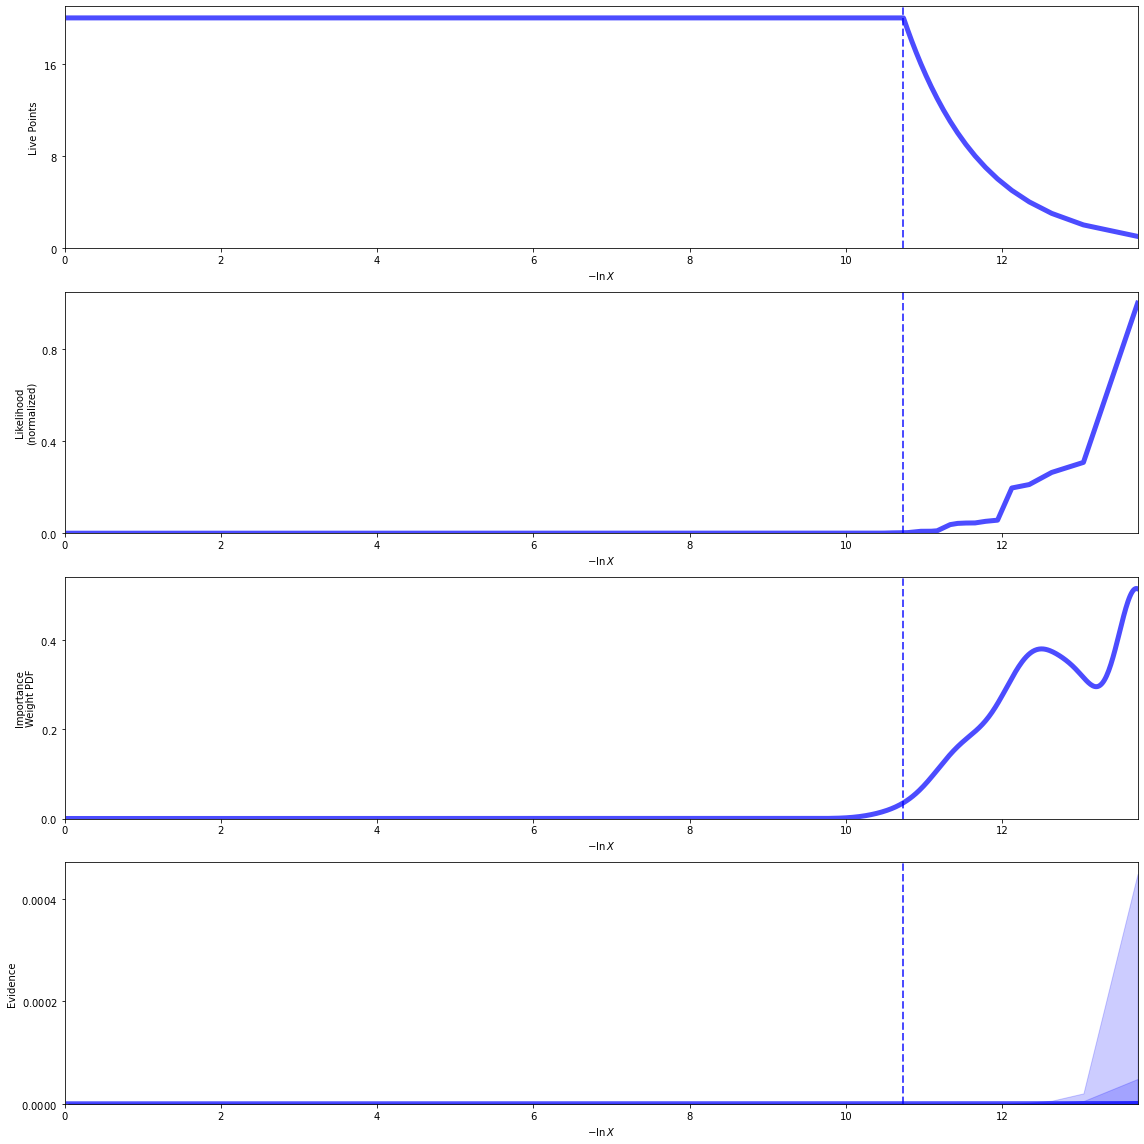

Quantiles:
$x_{1}$ [(0.025, 0.27784635807714375), (0.5, 0.6654843324097209), (0.975, 0.9862991335978861)]
Quantiles:
$x_{2}$ [(0.025, -1.0834171885466566), (0.5, -0.6622919188055066), (0.975, -0.40395005512731597)]
Quantiles:
$x_{3}$ [(0.025, -0.09996228904276865), (0.5, 0.41001497011823573), (0.975, 0.6189508743445928)]
Quantiles:
$x_{4}$ [(0.025, -1.117378828535105), (0.5, -0.39675799965073993), (0.975, 0.08143300056386789)]
Quantiles:
$x_{5}$ [(0.025, -1.651584400402617), (0.5, -1.0231603568099987), (0.975, -0.9102407835401449)]
Quantiles:
$x_{6}$ [(0.025, -0.6115016199207192), (0.5, -0.17769757266088004), (0.975, 0.6987231355412008)]
Quantiles:
$x_{7}$ [(0.025, -0.2610343234391119), (0.5, -0.04470626333493812), (0.975, 0.1930249849435257)]
Quantiles:
$x_{8}$ [(0.025, -0.32510094050532523), (0.5, 0.12994105315085325), (0.975, 0.3545622972498902)]
Quantiles:
$x_{9}$ [(0.025, -0.3604675974980268), (0.5, -0.2224074937434948), (0.975, 0.8081469268655651)]
Quantiles:
$x_{10}$ [(0.025, -0

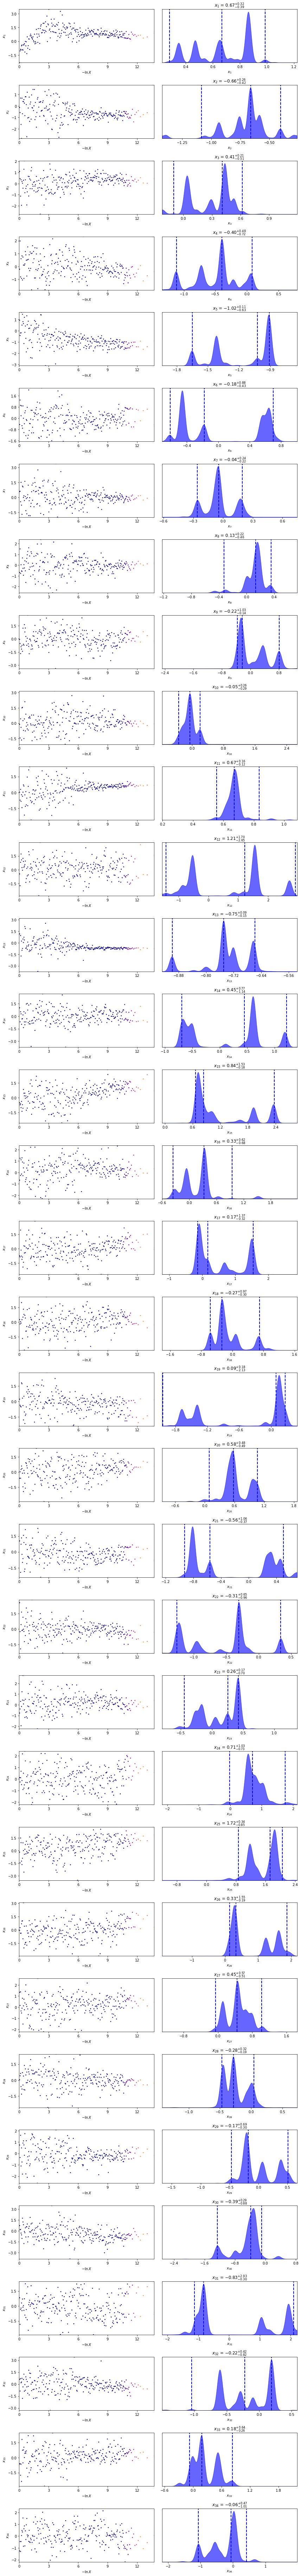

In [43]:
util.dyplot(results, cornerplot=False)

In [ ]:
%%timeit
import scipy

def objective(u):
    w = scipy.special.ndtri(u)
    return -float(loglike(w))


res = scipy.optimize.dual_annealing(objective, [(0., 1.)]*ndim, maxiter=100)

In [59]:
def lstsq(R, y, noise_power):
    D = jnp.eye(R.shape[1])
    Z = noise_power * D + R.T @ R
    L, lower = jax.scipy.linalg.cho_factor(Z, lower=True, check_finite=False)
    b = R.T @ y
    x = jax.scipy.linalg.cho_solve((L, lower), b, check_finite=False)
    return x

def setxlim(f, margin=0.05):
    ts = hyper['data']['fullt'][f != 0.]
    xlim(ts[0]*(1-margin), ts[-1]*(1+margin))

0	log L = -752.7305340659342	SNR [dB] = 16.31353068821072


DeviceArray(1.06299544, dtype=float64)

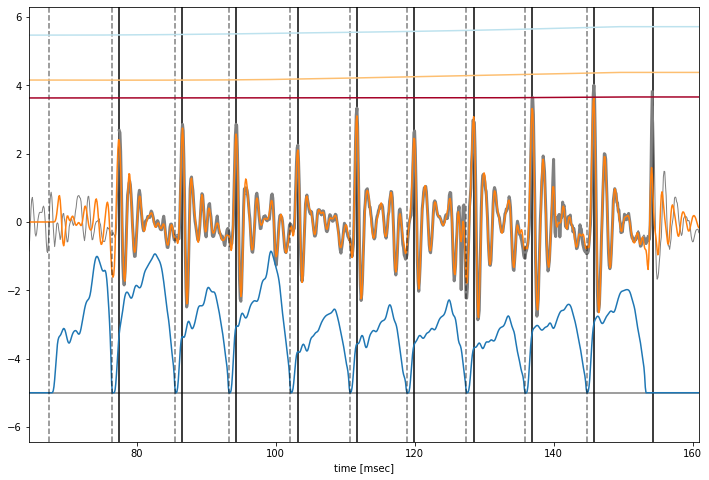

In [60]:
nsamp = 1

#w_samples = util.resample_equal(results, nsamp)
w_samples = [res.x]

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)
    offset = model.get_offset(delta, theta_source, hyper)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper, convolve=True
    )

    f_mean = lstsq(R, hyper['data']['d'], noise_sigma**2)

    hyper2 = process.hyper_fullt(hyper)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper['data']['fullt'], hyper['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)
    plot(hyper['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper['data']['fullt'], ft, label="f(t)", alpha=alpha)
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper['filter'].K)
        )

    #display(klatt.play(hyper['data']['t'], hyper['data']['d']))
    #display(klatt.play(hyper['data']['t'], ft))

delta

0	log L = -107793.12124576734	SNR [dB] = 32.57315543089709


DeviceArray(-0.75346558, dtype=float64)

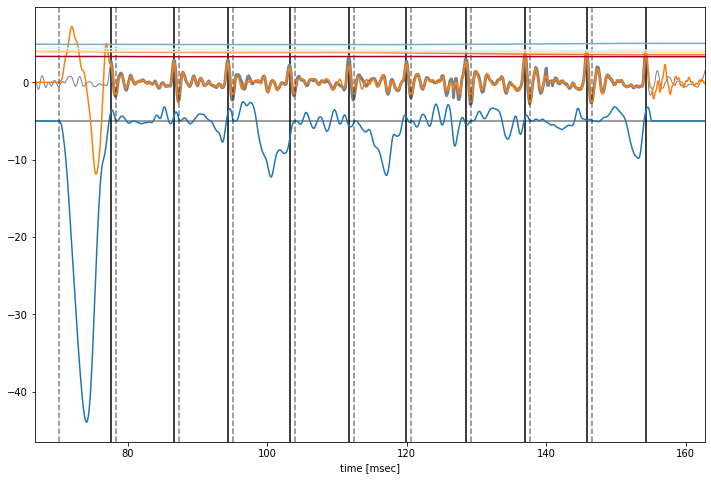

In [46]:
nsamp = 1

w_samples = [randn(ndim)]

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)
    offset = model.get_offset(delta, theta_source, hyper)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper, convolve=True
    )

    f_mean = lstsq(R, hyper['data']['d'], noise_sigma**2)

    hyper2 = process.hyper_fullt(hyper)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper['data']['fullt'], hyper['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)
    plot(hyper['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper['data']['fullt'], ft, label="f(t)", alpha=alpha)
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper['filter'].K)
        )

    #display(klatt.play(hyper['data']['t'], hyper['data']['d']))
    #display(klatt.play(hyper['data']['t'], ft))

delta

In [61]:
model.unpack_theta(theta, hyper)

(DeviceArray(0.15287042, dtype=float64),
 DeviceArray(1.06299544, dtype=float64),
 {'Oq': DeviceArray([0.95655019, 0.96311094, 0.97773704, 0.97226998, 0.98181782,
               0.98443683, 0.98763282, 0.99032959, 0.99166801, 0.99400334],            dtype=float64),
  'T': DeviceArray([8.9848181 , 9.10000081, 7.70000026, 8.90000005, 8.50000013,
               8.20000028, 8.60000059, 8.40000053, 8.90000065, 8.50000008],            dtype=float64),
  'r': DeviceArray([0.28890688, 0.31070954, 0.36271199, 0.34380602, 0.38688672,
               0.42703547, 0.43187287, 0.4751569 , 0.49067903, 0.53514051],            dtype=float64),
  'var_sigma': DeviceArray([2.96629629, 3.31569651, 3.38380571, 3.53856247, 3.80200781,
               4.02500495, 4.14160435, 4.42353988, 4.47369215, 4.7123252 ],            dtype=float64)},
 {'g': DeviceArray([[0.83260145],
               [1.35397646],
               [1.84852797],
               [1.51559328],
               [2.17067127],
               [2.16823018

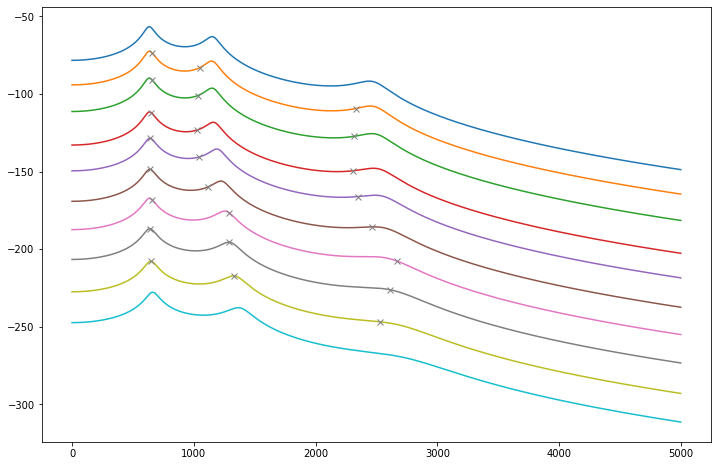

In [62]:
f = constants.spectrum_frequencies()

powers = jax.vmap(hyper['filter'].transfer_function_power_dB, (None, 0, 0, 0))(
    f, theta_filter['x'], theta_filter['y'], theta_filter['g']
)

for i, power in enumerate(powers):
    plot(f, power - i*20)
    
    F = hyper['data']['F_estimate'][i,:]
    estim = np.interp(F, f, power - i*20)
    plot(F, estim, 'x', color="grey")

## Jaxns testing

In [7]:
import jaxns
import tensorflow_probability.substrates.jax.distributions as tfd

In [22]:
def prior_model():
    w = yield jaxns.Prior(
        tfd.MultivariateNormalDiag(scale_diag=jnp.ones(ndim)),
        name='w'
    )
    return w

exact_ns = jaxns.ExactNestedSampler(
    model=jaxns.Model(prior_model=prior_model, log_likelihood=loglike),
    num_live_points=ndim*3,
    num_parallel_samplers=1,
    max_samples=1e4 ### <---- 1e4
)

In [ ]:
%%timeit
termination_reason, state = exact_ns(
    jaxkey(42),
    term_cond=jaxns.TerminationCondition(
        max_num_likelihood_evaluations=100,
        #live_evidence_frac=1e-2
    )
)

In [ ]:
results = exact_ns.to_results(state, termination_reason)